**实验进行细节**：

1. BWGNN的源码是用Dgl实现的，使用Dgl的Yelpchi以及Amazon数据集进行验证。模型先使用两层全连接层提取特征，之后使用Beta实现带通滤波的效果，最后使用两层全连接层进行分类任务。f1，auc可用

2. 原始的Deep_SVDD论文是应用在图像上的one-class classification，因此找到关于Deep_SVDD在图异常检测的论文。Graph_SVDD论文没使用任何库，纯torch实现，其中的earlystop类作用于val数据集，判断何时停止，值得学习。由于得到的是anomaly score，因此只能使用AUC作为评判指标。

**实验计划概览**：

1. 使用PYG的库实现BWGNN的基础模型。

2. 使用经典GCN网络实现Graph_SVDD且通过PYG构建（这个简单关键是损失函数的构架）。

3. 如上均使用Cora数据集进行验证，收集并记录实验数据，以备不时之需。对了，重要的是完善一个调参的模块，尽量找到模型的全局最优解。

4. 将如上两个模型进行表征融合（concate以及weighted aggregate），对比实验效果，并记录下调参后的所有验证数据。

In [1]:
from dgl.data import FraudYelpDataset, FraudAmazonDataset
from dgl.data.utils import load_graphs, save_graphs
import dgl
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
import numpy as np
import torch

class Dataset:
    def __init__(self, name='tfinance', homo=True, anomaly_alpha=None, anomaly_std=None):
        self.name = name
        graph = None
        if name == 'tsocial':
            graph, label_dict = load_graphs('dataset/tsocial')
            graph = graph[0]

        elif name == 'yelp':
            dataset = FraudYelpDataset()
            graph = dataset[0]
            if homo:
                graph = dgl.to_homogeneous(dataset[0], ndata=['feature', 'label', 'train_mask', 'val_mask', 'test_mask'])
                graph = dgl.add_self_loop(graph)
        elif name == 'amazon':
            dataset = FraudAmazonDataset()
            graph = dataset[0]
            if homo:
                graph = dgl.to_homogeneous(dataset[0], ndata=['feature', 'label', 'train_mask', 'val_mask', 'test_mask'])
                graph = dgl.add_self_loop(graph)
        elif name == 'cora':
            graph = Planetoid('../data/Cora','Cora',transform = T.NormalizeFeatures())[0]
        else:
            print('no such dataset')
            exit(1)

        # graph.ndata['label'] = graph.ndata['label'].long().squeeze(-1)
        # graph.ndata['feature'] = graph.ndata['feature'].float()
        self.graph = graph


F:\anaconda\envs\pygod2\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
graph = Dataset("cora").graph

import torch
from pygod.generator import gen_contextual_outliers,gen_structural_outliers

graph, yc = gen_contextual_outliers(graph,n=100,k=50)
graph, ys = gen_structural_outliers(graph,m=10,n=10)

graph.y = yc.logical_or(ys).to(torch.long)
graph

Data(x=[2708, 1433], edge_index=[2, 11456], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [3]:
import torch_sparse
# torch_sparse.SparseTensor(graph.edge_index[0],graph.edge_index[1])
isinstance(graph.edge_index,torch_sparse.SparseTensor)
edge_index = torch_sparse.SparseTensor.from_edge_index(graph.edge_index)
# isinstance(edge_index,torch_sparse.SparseTensor)
edge_index

SparseTensor(row=tensor([   0,    0,    0,  ..., 2707, 2707, 2707]),
             col=tensor([ 633, 1862, 2582,  ...,  598, 1473, 2706]),
             size=(2708, 2708), nnz=11456, density=0.16%)

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import dgl.function as fn
import dgl
import sympy
import scipy
import numpy as np
from torch import nn
from torch.nn import init
# from dgl.nn.pytorch import GraphConv, EdgeWeightNorm, ChebConv, GATConv, HeteroGraphConv
from torch_geometric.nn.conv.gcn_conv import gcn_norm
from torch_geometric.nn.conv.message_passing import MessagePassing 
import IPython

class PolyConv(nn.Module):
    def __init__(self,
                 in_feats,
                 out_feats,
                 theta,
                 activation=F.leaky_relu,
                 lin=False,
                 bias=False):
        super(PolyConv, self).__init__()
        self._theta = theta
        self._k = len(self._theta)
        self._in_feats = in_feats
        self._out_feats = out_feats
        self.activation = activation
        self.linear = nn.Linear(in_feats, out_feats, bias)
        self.lin = lin
        
        # self.reset_parameters()
        # self.linear2 = nn.Linear(out_feats, out_feats, bias)

    def reset_parameters(self):
        if self.linear.weight is not None:
            init.xavier_uniform_(self.linear.weight)
        if self.linear.bias is not None:
            init.zeros_(self.linear.bias)

    def forward(self, graph, feat):
        # def unnLaplacian(feat, D_invsqrt, graph):
        #     """ Operation D^-1/2 A D^-1/2 * Feat
        #         However, inverse computation for saving time!!!
        #         which means no need matric computation and only simple mul solved."""
        #     graph.ndata['h'] = feat * D_invsqrt
        #     graph.update_all(fn.copy_u('h', 'm'), fn.sum('m', 'h'))
        #     return feat - graph.ndata.pop('h') * D_invsqrt
        
        # with graph.local_scope():
        # D_invsqrt = torch.pow(graph.in_degrees().float().clamp(
        #     min=1), -0.5).unsqueeze(-1).to(feat.device)
        h = self._theta[0]*feat
        for k in range(1, self._k):
            edge_index, edge_weight = gcn_norm(edge_index=graph.edge_index,add_self_loops=False)
            out = MessagePassing().propagate(edge_index=edge_index,x=feat,edge_weight = edge_weight)
            # feat = unnLaplacian(feat, D_invsqrt, graph)
            # transform GCN laplacian to symmetric normalized laplacian.

            feat = feat - out
            h += self._theta[k]*feat
        if self.lin:
            h = self.linear(h)
            h = self.activation(h)
        return h


def calculate_theta2(d):
    thetas = []
    x = sympy.symbols('x')
    for i in range(d+1):
        f = sympy.poly((x/2) ** i * (1 - x/2) ** (d-i) / (scipy.special.beta(i+1, d+1-i)))
        coeff = f.all_coeffs()
        inv_coeff = []
        for i in range(d+1):
            inv_coeff.append(float(coeff[d-i]))
        thetas.append(inv_coeff)
    return thetas


class BWGNN(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes, graph, d=2, batch=False):
        super(BWGNN, self).__init__()
        self.g = graph
        self.thetas = calculate_theta2(d=d)
        self.conv = []
        for i in range(len(self.thetas)):
            if not batch:
                self.conv.append(PolyConv(h_feats, h_feats, self.thetas[i], lin=False))
        self.linear = nn.Linear(in_feats, h_feats)
        self.linear2 = nn.Linear(h_feats, h_feats)
        self.linear3 = nn.Linear(h_feats*len(self.conv), h_feats)
        self.linear4 = nn.Linear(h_feats, num_classes)
        self.act = nn.ReLU()
        self.d = d

    def forward(self, in_feat):
        h = self.linear(in_feat)
        h = self.act(h)
        h = self.linear2(h)
        h = self.act(h)
        h_final = torch.zeros([len(in_feat), 0])
        for conv in self.conv:
            # 改变 GCN 的聚合方式，设计自己的带通滤波器
            h0 = conv(self.g, h)
            h_final = torch.cat([h_final, h0], -1)
            # print(h_final.shape)
        h = self.linear3(h_final)
        h = self.act(h)
        h = self.linear4(h)
        return h
        
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

train/dev/test samples:  1083 536 1089
cross entropy weight:  12.884615384615385
Epoch 0/100, loss: 0.6487, val f1: 0.6352, val recall: 0.5641, val precision: 0.2588, val auc: 0.7668,   (best 0.6352)
EarlyStopping counter: 1 out of 20
Epoch 1/100, loss: 2.5300, val f1: 0.4391, val recall: 0.8462, val precision: 0.1191, val auc: 0.7721,   (best 0.6352)
EarlyStopping counter: 2 out of 20
Epoch 2/100, loss: 1.2406, val f1: 0.4811, val recall: 0.0000, val precision: 0.0000, val auc: 0.2324,   (best 0.6352)
EarlyStopping counter: 3 out of 20
Epoch 3/100, loss: 0.7827, val f1: 0.6455, val recall: 0.5641, val precision: 0.2750, val auc: 0.7714,   (best 0.6455)
EarlyStopping counter: 4 out of 20
Epoch 4/100, loss: 0.8436, val f1: 0.6454, val recall: 0.5128, val precision: 0.2817, val auc: 0.7714,   (best 0.6455)
EarlyStopping counter: 5 out of 20
Epoch 5/100, loss: 0.6819, val f1: 0.6463, val recall: 0.4872, val precision: 0.2879, val auc: 0.7718,   (best 0.6463)
EarlyStopping counter: 6 out o

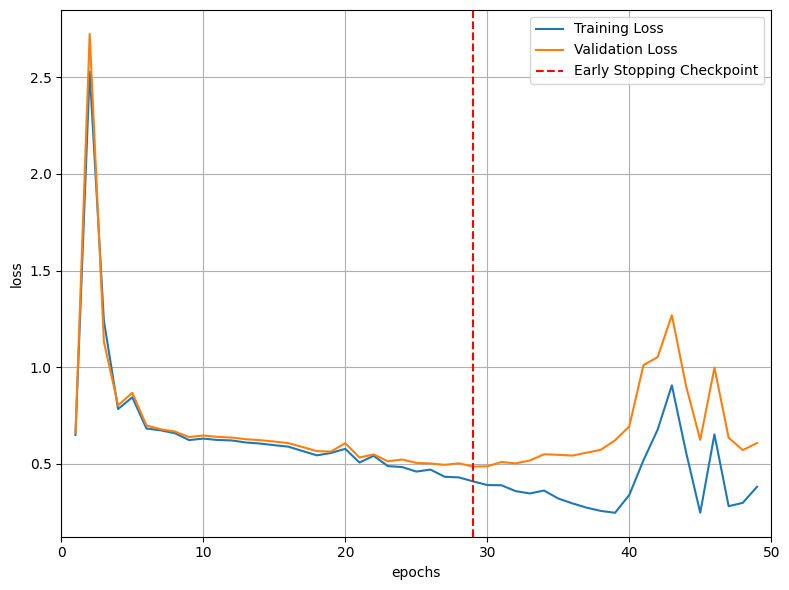

train/dev/test samples:  1083 536 1089
cross entropy weight:  12.884615384615385
Epoch 0/100, loss: 0.9239, val f1: 0.4811, val recall: 0.0000, val precision: 0.0000, val auc: 0.2307,   (best 0.4811)
EarlyStopping counter: 1 out of 20
Epoch 1/100, loss: 2.1184, val f1: 0.4767, val recall: 0.8205, val precision: 0.1322, val auc: 0.7710,   (best 0.4811)
Epoch 2/100, loss: 0.7067, val f1: 0.6332, val recall: 0.4872, val precision: 0.2639, val auc: 0.7692,   (best 0.6332)
EarlyStopping counter: 1 out of 20
Epoch 3/100, loss: 5.0855, val f1: 0.4811, val recall: 0.0000, val precision: 0.0000, val auc: 0.2299,   (best 0.6332)
EarlyStopping counter: 2 out of 20
Epoch 4/100, loss: 1.5143, val f1: 0.4811, val recall: 0.0000, val precision: 0.0000, val auc: 0.2295,   (best 0.6332)
EarlyStopping counter: 3 out of 20
Epoch 5/100, loss: 1.2039, val f1: 0.5741, val recall: 0.6667, val precision: 0.1857, val auc: 0.7697,   (best 0.6332)
EarlyStopping counter: 4 out of 20
Epoch 6/100, loss: 1.4532, val

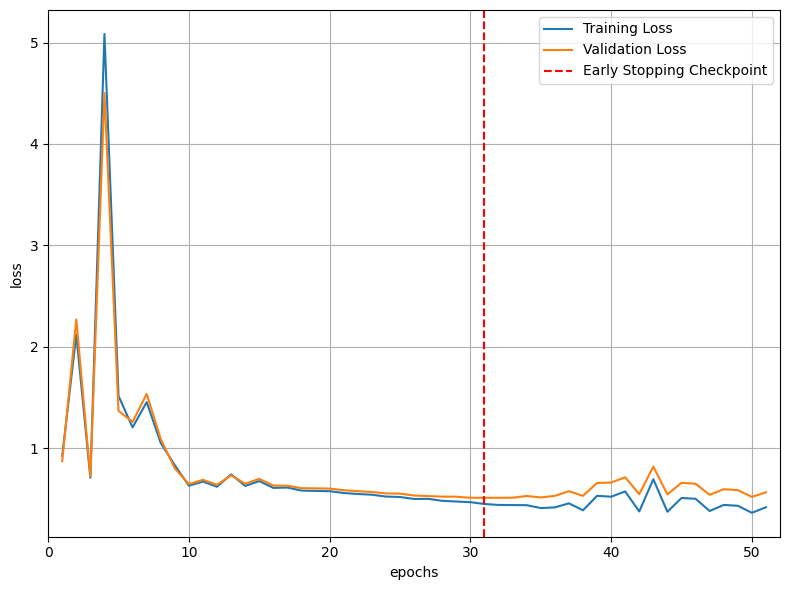

train/dev/test samples:  1083 536 1089
cross entropy weight:  12.884615384615385
Epoch 0/100, loss: 0.6829, val f1: 0.5274, val recall: 0.3846, val precision: 0.1282, val auc: 0.6773,   (best 0.5274)
EarlyStopping counter: 1 out of 20
Epoch 1/100, loss: 3.3632, val f1: 0.3927, val recall: 0.9231, val precision: 0.1108, val auc: 0.7858,   (best 0.5274)
EarlyStopping counter: 2 out of 20
Epoch 2/100, loss: 1.3139, val f1: 0.5735, val recall: 0.6923, val precision: 0.1862, val auc: 0.7708,   (best 0.5735)
EarlyStopping counter: 3 out of 20
Epoch 3/100, loss: 2.4415, val f1: 0.4811, val recall: 0.0000, val precision: 0.0000, val auc: 0.2307,   (best 0.5735)
EarlyStopping counter: 4 out of 20
Epoch 4/100, loss: 1.0141, val f1: 0.4811, val recall: 0.0000, val precision: 0.0000, val auc: 0.2322,   (best 0.5735)
EarlyStopping counter: 5 out of 20
Epoch 5/100, loss: 0.7917, val f1: 0.6393, val recall: 0.5641, val precision: 0.2651, val auc: 0.7718,   (best 0.6393)
EarlyStopping counter: 6 out o

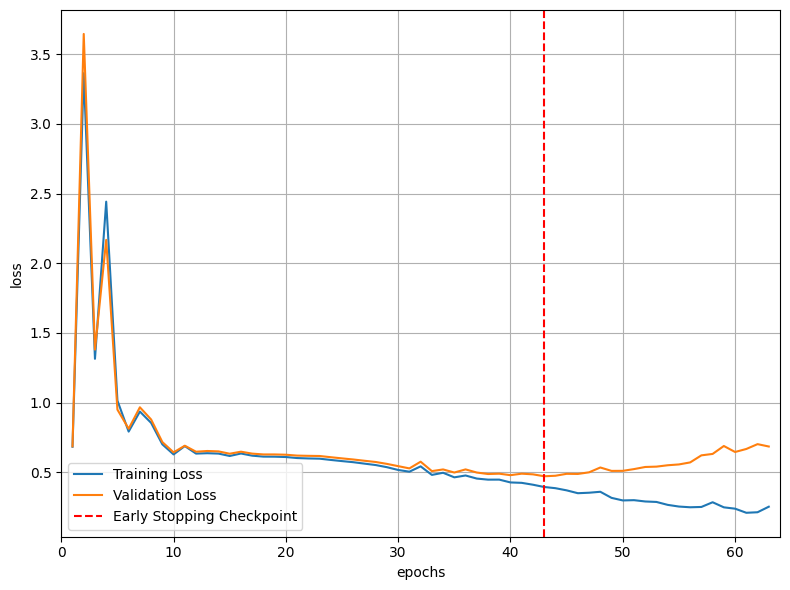

train/dev/test samples:  1083 536 1089
cross entropy weight:  12.884615384615385
Epoch 0/100, loss: 0.8943, val f1: 0.4811, val recall: 0.0000, val precision: 0.0000, val auc: 0.2320,   (best 0.4811)
EarlyStopping counter: 1 out of 20
Epoch 1/100, loss: 3.1531, val f1: 0.4015, val recall: 0.9231, val precision: 0.1132, val auc: 0.7840,   (best 0.4811)
EarlyStopping counter: 2 out of 20
Epoch 2/100, loss: 1.8277, val f1: 0.5106, val recall: 0.7692, val precision: 0.1456, val auc: 0.7700,   (best 0.5106)
EarlyStopping counter: 3 out of 20
Epoch 3/100, loss: 1.6979, val f1: 0.4811, val recall: 0.0000, val precision: 0.0000, val auc: 0.2291,   (best 0.5106)
Epoch 4/100, loss: 0.6953, val f1: 0.6443, val recall: 0.5897, val precision: 0.2706, val auc: 0.7698,   (best 0.6443)
EarlyStopping counter: 1 out of 20
Epoch 5/100, loss: 0.8700, val f1: 0.6454, val recall: 0.5128, val precision: 0.2817, val auc: 0.7710,   (best 0.6454)
EarlyStopping counter: 2 out of 20
Epoch 6/100, loss: 0.7773, val

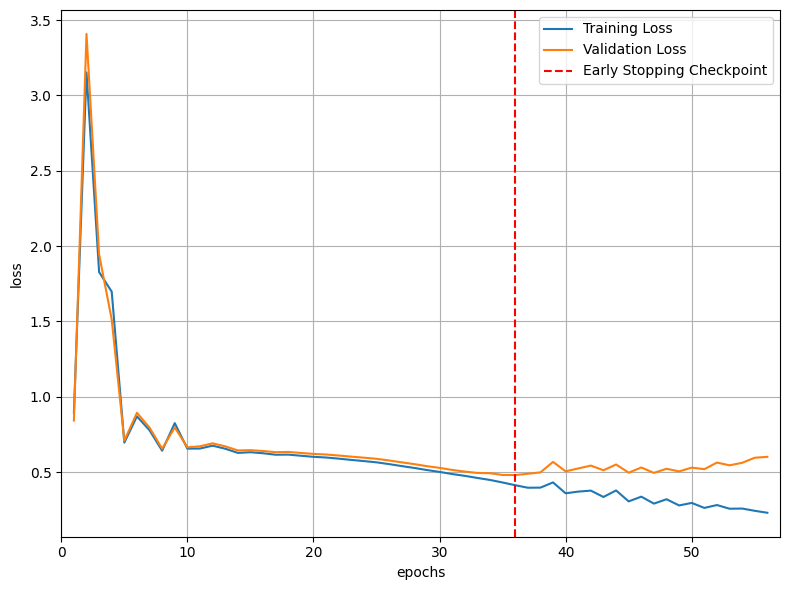

train/dev/test samples:  1083 536 1089
cross entropy weight:  12.884615384615385
Epoch 0/100, loss: 0.6598, val f1: 0.6413, val recall: 0.5641, val precision: 0.2683, val auc: 0.7704,   (best 0.6413)
EarlyStopping counter: 1 out of 20
Epoch 1/100, loss: 7.3337, val f1: 0.4811, val recall: 0.0000, val precision: 0.0000, val auc: 0.2307,   (best 0.6413)
EarlyStopping counter: 2 out of 20
Epoch 2/100, loss: 2.9014, val f1: 0.4811, val recall: 0.0000, val precision: 0.0000, val auc: 0.2299,   (best 0.6413)
EarlyStopping counter: 3 out of 20
Epoch 3/100, loss: 0.8035, val f1: 0.4811, val recall: 0.0000, val precision: 0.0000, val auc: 0.2349,   (best 0.6413)
Epoch 4/100, loss: 0.6393, val f1: 0.6533, val recall: 0.5385, val precision: 0.2917, val auc: 0.7702,   (best 0.6533)
EarlyStopping counter: 1 out of 20
Epoch 5/100, loss: 0.6450, val f1: 0.6393, val recall: 0.5641, val precision: 0.2651, val auc: 0.7701,   (best 0.6533)
EarlyStopping counter: 2 out of 20
Epoch 6/100, loss: 0.6395, val

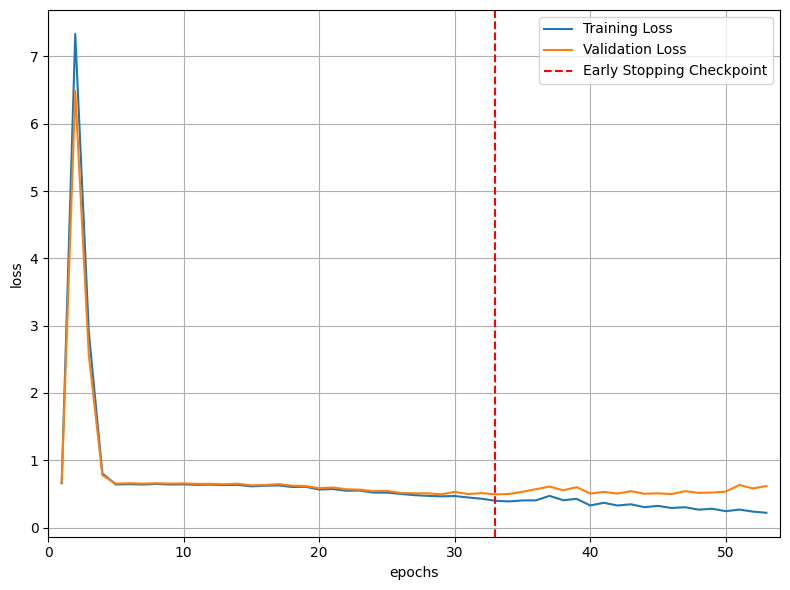

MF1-mean: 76.76, MF1-std: 3.44, AUC-mean: 78.74, AUC-std: 0.64


In [24]:
import dgl
import torch
import torch.nn.functional as F
import numpy as np
import argparse
import time
from sklearn.metrics import f1_score, accuracy_score, recall_score, roc_auc_score, precision_score, confusion_matrix
from sklearn.model_selection import train_test_split
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

def plot_earlystop(train_losses, val_losses):
    fig = plt.figure(figsize=(8,6))
    plt.plot(range(1,len(train_losses)+1),train_losses, label='Training Loss')
    plt.plot(range(1,len(val_losses)+1),val_losses,label='Validation Loss')

    # find position of lowest validation loss
    minposs = val_losses.index(min(val_losses))+1 
    plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

    plt.xlabel('epochs')
    plt.ylabel('loss')
    # plt.ylim(0.0, 1.5) # consistent scale
    plt.xlim(0, len(train_losses)+1) # consistent scale
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    # fig.savefig('loss_plot.png', bbox_inches='tight')

def train(model, g, args):
    features = g.x
    labels = g.y
    index = list(range(len(labels)))
    # if dataset_name == 'amazon':
    #     index = list(range(3305, len(labels)))

    idx_train, idx_rest, y_train, y_rest = train_test_split(index, labels[index], stratify=labels[index],
                                                            train_size=args.train_ratio,
                                                            random_state=2, shuffle=True)
    idx_valid, idx_test, y_valid, y_test = train_test_split(idx_rest, y_rest, stratify=y_rest,
                                                            test_size=0.67,
                                                            random_state=2, shuffle=True)
    train_mask = torch.zeros([len(labels)]).bool()
    val_mask = torch.zeros([len(labels)]).bool()
    test_mask = torch.zeros([len(labels)]).bool()

    train_mask[idx_train] = 1
    val_mask[idx_valid] = 1
    test_mask[idx_test] = 1
    train_losses = []
    val_losses = []
    print('train/dev/test samples: ', train_mask.sum().item(), val_mask.sum().item(), test_mask.sum().item())
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    best_f1, final_tf1, final_trec, final_tpre, final_tmf1, final_tauc = 0., 0., 0., 0., 0., 0.

    weight = (1-labels[train_mask]).sum().item() / labels[train_mask].sum().item()
    print('cross entropy weight: ', weight)
    early_stopping = EarlyStopping(patience=20)
    time_start = time.time()
    for e in range(args.epoch):
        model.train()
        logits = model(features)
        loss = F.cross_entropy(logits[train_mask], labels[train_mask], weight=torch.tensor([1., weight]))
        train_losses.append(loss.detach().item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        model.eval()
        loss_val = F.cross_entropy(logits[val_mask], labels[val_mask], weight=torch.tensor([1., weight]))
        val_losses.append(loss_val.detach().item())
        early_stopping(loss_val, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break

        probs = logits.softmax(1)
        # 在验证集中选择最好的threshold，来求f1 score
        f1, thres = get_best_f1(labels[val_mask], probs[val_mask])
        preds = np.zeros_like(labels)
        preds[probs[:, 1] > thres] = 1

        trec = recall_score(labels[val_mask], preds[val_mask])
        tpre = precision_score(labels[val_mask], preds[val_mask])
        tauc = roc_auc_score(labels[val_mask], probs[val_mask][:, 1].detach().numpy())
        if best_f1 < f1:
            best_f1 = f1
        print('Epoch {}/{}, loss: {:.4f}, val f1: {:.4f}, val recall: {:.4f}, val precision: {:.4f}, val auc: {:.4f},   (best {:.4f})'
        .format(e, args.epoch, loss, f1, trec, tpre, tauc, best_f1))

    # test
    model.eval()
    probs = logits.softmax(1)
    # 在测试集中选择最好的threshold，来求f1 score
    f1, thres = get_best_f1(labels[test_mask], probs[test_mask])
    
    preds = np.zeros_like(labels)
    preds[probs[:, 1] > thres] = 1
    preds[probs[:, 1] < thres] = 0
    trec = recall_score(labels[test_mask], preds[test_mask])
    tpre = precision_score(labels[test_mask], preds[test_mask])
    tauc = roc_auc_score(labels[test_mask], probs[test_mask][:, 1].detach().numpy())
    time_end = time.time()

    print('time cost: ', time_end - time_start, 's')
    print('Test: THRESHOLD {:.2f}, REC {:.2f} PRE {:.2f} F1 {:.2f} AUC {:.2f}'.format(thres*100, trec*100,
                                                                     tpre*100, f1*100, tauc*100))
    return f1, tauc, train_losses,val_losses


# threshold adjusting for best macro f1
def get_best_f1(labels, probs):
    best_f1, best_thre = 0, 0
    for thres in np.linspace(0.05, 0.95, 19):
        preds = np.zeros_like(labels)
        preds[probs[:,1] > thres] = 1
        mf1 = f1_score(labels, preds, average='macro')
        if mf1 > best_f1:
            best_f1 = mf1
            best_thre = thres
    return best_f1, best_thre


parser = argparse.ArgumentParser(description='BWGNN')
parser.add_argument("--dataset", type=str, default="cora",
                    help="Dataset for this model (yelp/amazon/tfinance/tsocial)")
parser.add_argument("--train_ratio", type=float, default=0.4, help="Training ratio")
parser.add_argument("--hid_dim", type=int, default=64, help="Hidden layer dimension")
parser.add_argument("--order", type=int, default=2, help="Order C in Beta Wavelet")
parser.add_argument("--homo", type=int, default=1, help="1 for BWGNN(Homo) and 0 for BWGNN(Hetero)")
parser.add_argument("--epoch", type=int, default=100, help="The max number of epochs")
parser.add_argument("--run", type=int, default=5, help="Running times")

args, known = parser.parse_known_args()
dataset_name = args.dataset
homo = args.homo
order = args.order
h_feats = args.hid_dim
# graph = Dataset(dataset_name, homo).graph
in_feats = graph.num_node_features
num_classes = 2

if args.run == 1:
    if homo:
        model = BWGNN(in_feats, h_feats, num_classes, graph, d=order)
    _, _, train_loss, val_loss = train(model, graph, args)
    
    #  plot early stop curve
    plot_earlystop(train_loss, val_loss)
    # visualize the loss as the network trained

else:
    final_mf1s, final_aucs = [], []
    for tt in range(args.run):
        if homo:
            model = BWGNN(in_feats, h_feats, num_classes, graph, d=order)
        mf1, auc, train_loss, val_loss = train(model, graph, args)
        #  plot early stop curve
        plot_earlystop(train_loss, val_loss)
        final_mf1s.append(mf1)
        final_aucs.append(auc)
    final_mf1s = np.array(final_mf1s)
    final_aucs = np.array(final_aucs)
    print('MF1-mean: {:.2f}, MF1-std: {:.2f}, AUC-mean: {:.2f}, AUC-std: {:.2f}'.format(100 * np.mean(final_mf1s),
                                                                                        100 * np.std(final_mf1s),
                                                            100 * np.mean(final_aucs), 100 * np.std(final_aucs)))


In [21]:

# print (f"{ :.2f}")

2.56
